# Оглавление

1. [Импорт библиотек](#импорт-библиотек)
2. [Загрузка и предварительная обработка данных](#загрузка-и-предварительная-обработка-данных)
3. [Написание класса NN](#написание-класса-nn)
4. [Выбор гиперпараметров и обучение NN](#выбор-гиперпараметров-и-обучение-nn)
5. [Визуализация функции потерь и метрики Accuracy](#визуализация-функции-потерь-и-метрики-accuracy)
6. [Предсказание NN и сохранение результатов](#предсказание-nn-и-сохранение-результатов)

## Импорт библиотек

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Загрузка и предварительная обработка данных

In [19]:
train_data = pd.read_csv("/home/artem/Рабочий стол/work/МНИСТ/train.csv")
valid = pd.read_csv("/home/artem/Рабочий стол/work/МНИСТ/test.csv")

In [20]:
y_train = train_data['label']
X_train = train_data.drop(columns=['label'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [22]:
X_train = torch.tensor(X_train.values, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0
y_test = torch.tensor(y_test.values, dtype=torch.long)

valid = torch.tensor(valid.values, dtype=torch.float32).view(-1, 1, 28, 28) / 255.0

In [23]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [24]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [25]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=10), 
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.2)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [26]:
train_dataset = MNISTDataset(X_train, y_train, transform=transform)
test_dataset = MNISTDataset(X_test, y_test, transform=transforms.Normalize((0.1307,), (0.3081,)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [27]:
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

Train dataset: 33600 samples
Test dataset: 8400 samples


## Написание класса NN

In [28]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = LeNet5().to(device)

## Выбор гиперпараметров и обучение NN

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

epoch_plt, train_loss_plt, test_loss_plt, train_acc_plt, test_acc_plt = [], [], [], [], []

# Цикл обучения
for epoch in tqdm(range(epochs), total=epochs):
    model.train()  
    optimizer.zero_grad()

    y_logits = model(X_train)
    loss = loss_fn(y_logits, y_train)

    loss.backward()
    optimizer.step()

    _, predicted = torch.max(y_logits, 1)
    train_loss = loss.item()
    train_acc = 100 * (predicted == y_train).sum().item() / y_train.size(0)

    model.eval()
    with torch.no_grad():
        test_logits = model(X_test)
        test_loss = loss_fn(test_logits, y_test).item()

        _, predicted = torch.max(test_logits, 1)
        test_acc = 100 * (predicted == y_test).sum().item() / y_test.size(0)

    epoch_plt.append(epoch)
    train_loss_plt.append(train_loss / len(X_train))
    test_loss_plt.append(test_loss / len(X_test))
    train_acc_plt.append(train_acc)
    test_acc_plt.append(test_acc)

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}, "
              f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

  1%|          | 1/100 [00:03<05:28,  3.32s/it]

Epoch [1/100], Loss: 2.31840, Test Loss: 2.30000, Train Acc: 10.62%, Test Acc: 14.61%


 11%|█         | 11/100 [00:39<04:34,  3.08s/it]

Epoch [11/100], Loss: 1.79474, Test Loss: 2.15014, Train Acc: 45.82%, Test Acc: 51.12%


 21%|██        | 21/100 [01:06<03:25,  2.59s/it]

Epoch [21/100], Loss: 1.10733, Test Loss: 1.46219, Train Acc: 65.46%, Test Acc: 73.49%


 31%|███       | 31/100 [01:35<03:23,  2.95s/it]

Epoch [31/100], Loss: 0.67663, Test Loss: 0.63580, Train Acc: 78.96%, Test Acc: 86.75%


 41%|████      | 41/100 [02:08<03:11,  3.24s/it]

Epoch [41/100], Loss: 0.44441, Test Loss: 0.28547, Train Acc: 86.69%, Test Acc: 92.40%


 51%|█████     | 51/100 [02:36<02:16,  2.78s/it]

Epoch [51/100], Loss: 0.32237, Test Loss: 0.17348, Train Acc: 90.74%, Test Acc: 94.95%


 61%|██████    | 61/100 [03:03<01:43,  2.65s/it]

Epoch [61/100], Loss: 0.25317, Test Loss: 0.12342, Train Acc: 92.96%, Test Acc: 96.10%


 71%|███████   | 71/100 [03:29<01:17,  2.66s/it]

Epoch [71/100], Loss: 0.20244, Test Loss: 0.10082, Train Acc: 94.43%, Test Acc: 96.71%


 81%|████████  | 81/100 [03:58<00:54,  2.88s/it]

Epoch [81/100], Loss: 0.17954, Test Loss: 0.08665, Train Acc: 95.13%, Test Acc: 97.19%


 91%|█████████ | 91/100 [04:28<00:26,  2.97s/it]

Epoch [91/100], Loss: 0.15819, Test Loss: 0.07479, Train Acc: 95.66%, Test Acc: 97.56%


100%|██████████| 100/100 [04:55<00:00,  2.95s/it]

Epoch [100/100], Loss: 0.14280, Test Loss: 0.06760, Train Acc: 96.15%, Test Acc: 97.68%


## Визуализация функции потерь и метрики Accuracy

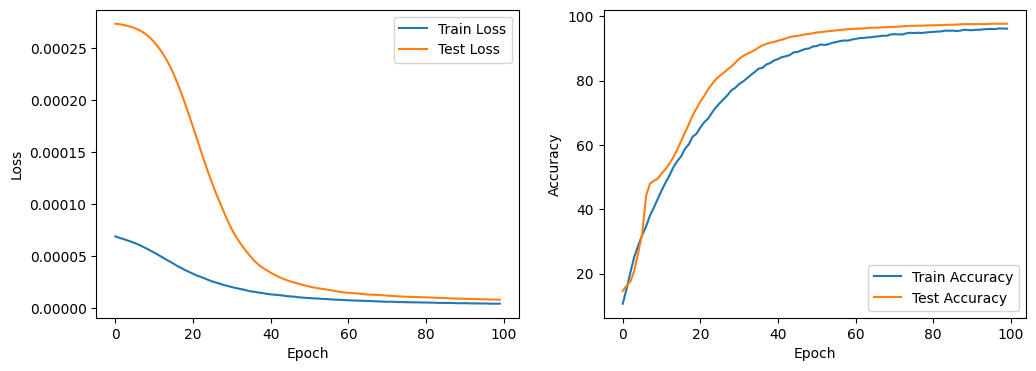

In [30]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epoch_plt, train_loss_plt, label='Train Loss')
plt.plot(epoch_plt, test_loss_plt, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_plt, train_acc_plt, label='Train Accuracy')
plt.plot(epoch_plt, test_acc_plt, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Предсказание NN и сохранение результатов

In [31]:
model.eval()
with torch.no_grad():
    valid_predictions = model(valid)
    valid_predictions = torch.argmax(valid_predictions, dim=1)

valid_predictions = valid_predictions.cpu().numpy()
submission = pd.DataFrame({'ImageId': range(1, len(valid_predictions) + 1), 'Label': valid_predictions})
submission.to_csv('submission.csv', index=False)

In [32]:
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
